In [84]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.layers import Embedding
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt

In [85]:
with open('data/train.dat', 'r') as f:
    reviews = f.read().rstrip('\n')
with open('data/train.labels', 'r') as f:
    labels = f.read().rstrip('\n')
with open('data/test.dat', 'r') as f:
    test_data = f.read().rstrip('\n')

In [86]:
punctuation = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~'''
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


# Removing words that have numbers in them
reviews = re.sub(r'\w*\d\w*', '', reviews)
test_data = re.sub(r'\w*\d\w*', '', test_data)

# Removing digits
reviews = re.sub(r'[0-9]+', '', reviews)
test_data = re.sub(r'[0-9]+', '', test_data)

# Setting every word to lower
reviews = reviews.lower()
test_data = test_data.lower()

# Dropping punctuation
reviews = ''.join([x for x in reviews if x not in punctuation])
test_data = ''.join([x for x in test_data if x not in punctuation])

reviews_split = reviews.split('\n')
test_data_split = test_data.split('\n')


In [87]:
labels_split = labels.split('\n')
encoded_labels = np.array([0 if label == '-1' else 1 for label in labels_split])

In [88]:
# Dropping stop words from training data
review_words = []
for review in reviews_split:
    review_words.append(review.split())
final = []
for review in review_words:
    tokens_without_sw = ' '.join([word for word in review if not word in stop_words])
    final.append(tokens_without_sw)

In [89]:
# Dropping stop words from test data
test_words = []
for review in test_data_split:
    test_words.append(review.split())
final_test = []
for review in test_words:
    tokens_without_sw = ' '.join([word for word in review if not word in stop_words])
    final_test.append(tokens_without_sw)

In [90]:
# max_words = 5000
# max_len = 200
max_words = 8000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(final)
sequences = tokenizer.texts_to_sequences(final)
features = pad_sequences(sequences, maxlen=max_len)
print(features.shape)

(25000, 500)


In [91]:
## split data into training and validation data (features and labels, x and y)
split_frac = 0.8

split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = encoded_labels[:split_idx], encoded_labels[split_idx:len(features)]


## print out the shapes of your resultant feature data
print("\t\t\tFeatures Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape))

			Features Shapes:
Train set: 		(20000, 500) 
Validation set: 	(5000, 500)


In [92]:
train_y = to_categorical(train_y, 2)
val_y = to_categorical(val_y, 2)

In [93]:
embedding_layer = Embedding(1000, 64)

In [62]:
model_lstm = Sequential()
model_lstm.add(layers.Embedding(max_words, 20)) #The embedding layer
model_lstm.add(layers.LSTM(15,dropout=0.5)) #My LSTM layer
model_lstm.add(layers.Dense(2,activation='softmax'))

#model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint1 = ModelCheckpoint("best_model_lstm.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history = model_lstm.fit(train_x, train_y, epochs=5,validation_data=(val_x, val_y),callbacks=[checkpoint1])

Epoch 1/5
624/625 [============================>.] - ETA: 0s - loss: 0.4417 - accuracy: 0.7882
Epoch 00001: val_accuracy improved from -inf to 0.87700, saving model to best_model_lstm.hdf5
625/625 [==============================] - 12s 20ms/step - loss: 0.4413 - accuracy: 0.7885 - val_loss: 0.3079 - val_accuracy: 0.8770
Epoch 2/5
624/625 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8911
Epoch 00002: val_accuracy improved from 0.87700 to 0.89340, saving model to best_model_lstm.hdf5
625/625 [==============================] - 14s 22ms/step - loss: 0.2717 - accuracy: 0.8911 - val_loss: 0.2789 - val_accuracy: 0.8934
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9087
Epoch 00003: val_accuracy improved from 0.89340 to 0.89380, saving model to best_model_lstm.hdf5
625/625 [==============================] - 11s 18ms/step - loss: 0.2351 - accuracy: 0.9087 - val_loss: 0.2718 - val_accuracy: 0.8938
Epoch 4/5
622/625 [=========

In [95]:
model_bidirec = Sequential()
model_bidirec.add(layers.Embedding(max_words, 40, input_length=max_len))
model_bidirec.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model_bidirec.add(layers.Dense(2,activation='softmax'))
model_bidirec.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model_bidirec.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history = model_bidirec.fit(train_x, train_y, epochs=10,validation_data=(val_x, val_y),callbacks=[checkpoint2])

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.7954
Epoch 00001: val_accuracy improved from -inf to 0.86540, saving model to best_model_bidirec.hdf5
625/625 [==============================] - 24s 38ms/step - loss: 0.4312 - accuracy: 0.7954 - val_loss: 0.3306 - val_accuracy: 0.8654
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8920
Epoch 00002: val_accuracy improved from 0.86540 to 0.88800, saving model to best_model_bidirec.hdf5
625/625 [==============================] - 24s 38ms/step - loss: 0.2684 - accuracy: 0.8920 - val_loss: 0.2738 - val_accuracy: 0.8880
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.9080
Epoch 00003: val_accuracy did not improve from 0.88800
625/625 [==============================] - 24s 38ms/step - loss: 0.2337 - accuracy: 0.9079 - val_loss: 0.2769 - val_accuracy: 0.8878
Epoch 4/10
625/625 [==============================] - ETA: 0s

In [30]:
model_gru = Sequential()
model_gru.add(layers.Embedding(max_words, 40, input_length=max_len))
model_gru.add(layers.GRU(20,dropout=0.6))
model_gru.add(layers.Dense(2,activation='softmax'))
model_gru.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model_gru.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
history = model_gru.fit(train_x, train_y, epochs=5,validation_data=(val_x, val_y),callbacks=[checkpoint3])

Epoch 1/5
624/625 [============================>.] - ETA: 0s - loss: 0.4535 - accuracy: 0.7671
Epoch 00001: val_accuracy improved from -inf to 0.87740, saving model to best_model_gru.hdf5
625/625 [==============================] - 13s 21ms/step - loss: 0.4532 - accuracy: 0.7671 - val_loss: 0.2925 - val_accuracy: 0.8774
Epoch 2/5
623/625 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.8876
Epoch 00002: val_accuracy improved from 0.87740 to 0.88700, saving model to best_model_gru.hdf5
625/625 [==============================] - 15s 23ms/step - loss: 0.2750 - accuracy: 0.8876 - val_loss: 0.2746 - val_accuracy: 0.8870
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9078
Epoch 00003: val_accuracy improved from 0.88700 to 0.89080, saving model to best_model_gru.hdf5
625/625 [==============================] - 12s 19ms/step - loss: 0.2354 - accuracy: 0.9078 - val_loss: 0.2738 - val_accuracy: 0.8908
Epoch 4/5
624/625 [============

In [96]:
sentiment = ['-1', '+1']
sequence = tokenizer.texts_to_sequences(final_test)
test = pad_sequences(sequence, maxlen=max_len)

In [64]:
model_lstm=load_model('best_model_lstm.hdf5')
output_lstm = model_lstm.predict(test)

In [97]:
model_bidirec=load_model('best_model_bidirec.hdf5')
output_bidirec = model_bidirec.predict(test)

In [32]:
model_gru=load_model('best_model_gru.hdf5')
output_gru = model_gru.predict(test)

In [65]:
predictions_lstm = []
for line in output_lstm:
    max_val = np.max(line)
    idx = np.where(line == max_val)
    predictions_lstm.append(sentiment[int(idx[0])])

In [98]:
predictions_bidirec = []
for line in output_bidirec:
    max_val = np.max(line)
    idx = np.where(line == max_val)
    predictions_bidirec.append(sentiment[int(idx[0])])

In [33]:
predictions_gru = []
for line in output_gru:
    max_val = np.max(line)
    idx = np.where(line == max_val)
    predictions_gru.append(sentiment[int(idx[0])])

In [66]:
with open("output_lstm.txt", "w") as txt_file:
    for line in predictions_lstm:
        txt_file.write(str(line)+'\n')

In [99]:
with open("output_bidirec.txt", "w") as txt_file:
    for line in predictions_bidirec:
        txt_file.write(str(line)+'\n')

In [34]:
with open("output_gru.txt", "w") as txt_file:
    for line in predictions_gru:
        txt_file.write(str(line)+'\n')

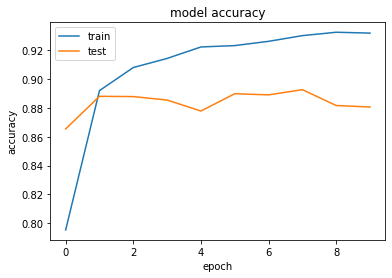

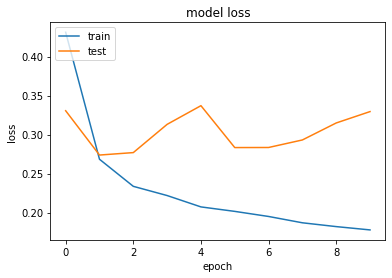

In [100]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()